# MVA - Homework 1 - Reinforcement Learning (2021/2022)

**Name:** MASQUIL Elías

## Instructions

* The deadline is **November 12 at 11:59 pm (Paris time).**

* By doing this homework you agree to the late day policy, collaboration and misconduct rules reported on [Piazza](https://piazza.com/class/ktmvsc4knke4ia?cid=6).

* **Mysterious or unsupported answers will not receive full credit**. A correct answer, unsupported by calculations, explanation, or algebraic work will receive no credit; an incorrect answer supported by substantially correct calculations and explanations might still receive partial credit.

* Answers should be provided in **English**.

# Colab setup

In [61]:
from IPython import get_ipython

if 'google.colab' in str(get_ipython()):
  # install rlberry library
  !pip install git+https://github.com/rlberry-py/rlberry.git@mva2021#egg=rlberry[default] > /dev/null 2>&1

  # install ffmpeg-python for saving videos
  !pip install ffmpeg-python > /dev/null 2>&1

  # packages required to show video
  !pip install pyvirtualdisplay > /dev/null 2>&1
  !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

  print("Libraries installed, please restart the runtime!")


Libraries installed, please restart the runtime!


In [62]:
# Create directory for saving videos
!mkdir videos > /dev/null 2>&1

# Initialize display and import function to show videos
import rlberry.colab_utils.display_setup
from rlberry.colab_utils.display_setup import show_video

In [63]:
# Useful libraries
import numpy as np
import matplotlib.pyplot as plt

# Preparation

In the coding exercises, you will use a *grid-world* MDP, which is represented in Python using the interface provided by the [Gym](https://gym.openai.com/) library. The cells below show how to interact with this MDP and how to visualize it.


In [64]:
from rlberry.envs import GridWorld

def get_env():
  """Creates an instance of a grid-world MDP."""
  env = GridWorld(
      nrows=5,
      ncols=7,
      reward_at = {(0, 6):1.0},
      walls=((0, 4), (1, 4), (2, 4), (3, 4)),
      success_probability=0.9,
      terminal_states=((0, 6),)
  )
  return env

def render_policy(env, policy=None, horizon=50):
  """Visualize a policy in an environment

  Args:
    env: GridWorld
        environment where to run the policy
    policy: np.array
        matrix mapping states to action (Ns).
        If None, runs random policy.
    horizon: int
        maximum number of timesteps in the environment.
  """
  env.enable_rendering()
  state = env.reset()                       # get initial state
  for timestep in range(horizon):
      if policy is None:
        action = env.action_space.sample()  # take random actions
      else:
        action = policy[state]
      next_state, reward, is_terminal, info = env.step(action)
      state = next_state
      if is_terminal:
        break
  # save video and clear buffer
  env.save_video('./videos/gw.mp4', framerate=5)
  env.clear_render_buffer()
  env.disable_rendering()
  # show video
  show_video('./videos/gw.mp4')


In [65]:
# Create an environment and visualize it
env = get_env()
render_policy(env)  # visualize random policy

# The reward function and transition probabilities can be accessed through
# the R and P attributes:
print(f"Shape of the reward array = (S, A) = {env.R.shape}")
print(f"Shape of the transition array = (S, A, S) = {env.P.shape}")
print(f"Reward at (s, a) = (1, 0): {env.R[1, 0]}")
print(f"Prob[s\'=2 | s=1, a=0]: {env.P[1, 0, 2]}")
print(f"Number of states and actions: {env.Ns}, {env.Na}")

# The states in the griworld correspond to (row, col) coordinates.
# The environment provides a mapping between (row, col) and the index of
# each state:
print(f"Index of state (1, 0): {env.coord2index[(1, 0)]}")
print(f"Coordinates of state 5: {env.index2coord[5]}")

Shape of the reward array = (S, A) = (31, 4)
Shape of the transition array = (S, A, S) = (31, 4, 31)
Reward at (s, a) = (1, 0): 0.0
Prob[s'=2 | s=1, a=0]: 0.04999999999999999
Number of states and actions: 31, 4
Index of state (1, 0): 6
Coordinates of state 5: (0, 6)


# Part 1 - Dynamic Programming

## Question 1.1

Consider a general MDP with a discount factor of $\gamma < 1$. Assume that the horizon is infinite (so there is no termination). A policy $\pi$ in this MDP
induces a value function $V^\pi$. Suppose an affine transformation is applied to the reward, what is
the new value function? Is the optimal policy preserved?



### **Answer**
For the original MDP we have $V^\pi(s) = \mathbb{E}\big[\sum_{t=0}^\infty\gamma^tr(s_t, d_t(h_t)| s_0=s; \pi)\big]$.

Let's call $\tilde{V}^\pi$ the value function of the same policy in the new MDP, where an affine transformation was applied to the reward. The new reward is $\tilde{r}(.,.) = Ar(.,.) + b$.

$\tilde{V}^\pi(s) = \mathbb{E}\big[\sum_{t=0}^\infty\gamma^t\tilde{r}(s_t, d_t(h_t)| s_0=s; \pi)\big] = \mathbb{E}\big[\sum_{t=0}^\infty\gamma^t(Ar(s_t, d_t(h_t)| s_0=s; \pi) + b)\big]$

Then, the new value function is $\tilde{V}^\pi(s) = AV^\pi(s) + b \sum_{t=0}^\infty \gamma^t = AV^\pi(s) + \frac{b}{1-\gamma}$

---
The optimal policy will be preserved $\iff A\geq0$, let's see why:

The value of the original optimal policy in the new modified MDP is:
$V^*_{old}(s) = AV^*(s) + \frac{b}{1-\gamma}$.
This policy will be optimal iff satisfies the Optimal Bellman equation:
$V^*_{old}(s) = \max_{a \in A}\big\{Ar(s,a) + b + \gamma\sum_{s'}P(s'|s,a)V^*_{old}(s')\big\}$.

$\underline{A=0}$:

The Optimal Bellman equation is simply: $\frac{b}{1-\gamma} = \max_{a}\big\{b + \gamma\sum_{s'}P(s'|s,a)\frac{b}{1-\gamma}\big\} = b + \frac{b\gamma}{1-\gamma} = \frac{b}{1-\gamma}$. Thus the policy remains optimal.

$\underline{A>0}$:

$\max_{a}\big\{Ar(s,a) + b + \gamma\sum_{s'}P(s'|s,a)V^*_{old}(s')\big\} = \max_{a}\big\{Ar(s,a) + b + \gamma\sum_{s'}P(s'|s,a)(AV^*(s')+\frac{b}{1-\gamma})\big\}$

$... = A \max_{a}\big\{r(s,a) + \gamma\sum_{s'}P(s'|s,a)V^*(s')\big\} + \frac{b}{1-\gamma}$

From this, we can recognize that the $\max$ term is exactly $V^*(s)$, so

$V_{old}^*(s) = \max_{a}\big\{Ar(s,a) + b + \gamma\sum_{s'}P(s'|s,a)V^*_{old}(s')\big\}$

Then, the optimal policy is preserved.

$\underline{A<0}$:

$\max_{a}\big\{Ar(s,a) + b + \gamma\sum_{s'}P(s'|s,a)(AV^*(s')+\frac{b}{1-\gamma})\big\} = A \min_{a}\big\{r(s,a) + \gamma\sum_{s'}P(s'|s,a)V^*(s')\big\} + \frac{b}{1-\gamma}$

So the value function doesn't satifies the optimallity equation any longer, and the optimal policy changes.

## Question 1.2

Consider an infinite-horizon $\gamma$-discounted MDP. We denote by $Q^*$ the $Q$-function of the optimal policy $\pi^*$. Prove that, for any function $Q(s, a)$ (which is **not** necessarily the value function of a policy), the following inequality holds for any state $s$:

$$
V^{\pi_Q}(s) \geq V^*(s) - \frac{2}{1-\gamma}||Q^*-Q||_\infty,
$$

where $||Q^*-Q||_\infty = \max_{s, a} |Q^*(s, a) - Q(s, a)|$ and $\pi_Q(s) \in \arg\max_a Q(s, a)$. Can you use this result to show that any policy $\pi$ such that $\pi(s) \in \arg\max_a Q^*(s, a)$ is optimal?

### **Answer**
$V^*(s) - V^{\pi_Q}(s) = Q^*(s, \pi^*(s)) - Q^{\pi_Q}(s, \pi_Q(s)) + Q^*(s,\pi_Q(s)) - Q^*(s,\pi_Q(s))$

$V^*(s) - V^{\pi_Q}(s) = Q^*(s, \pi^*(s)) - Q^*(s,\pi_Q(s)) + \gamma \sum_{s'}P(s'/s, \pi_Q(s)) (V^*(s') - V^{\pi_Q}(s')$

Since $Q(s, \pi_Q(s)) \geq Q(s, a) \text{ }\forall a$ because of the definition of $\pi_Q$

$V^*(s) - V^{\pi_Q}(s) \leq  Q^*(s, \pi^*(s)) - Q(s, \pi^*(s))- Q^*(s,\pi_Q(s)) + Q(s, \pi_Q(s)) + \gamma \sum_{s'}P(s'/s, \pi_Q(s)) (V^*(s') - V^{\pi_Q}(s')$

$V^*(s) - V^{\pi_Q}(s) \leq 2||Q^* - Q||_{\infty} + \gamma \sum_{s'}P(s'/s, \pi_Q(s)) (V^*(s') - V^{\pi_Q}(s') $

$V^*(s) - V^{\pi_Q}(s) \leq 2||Q^* - Q||_{\infty} + \gamma ||V^* - V^{\pi_Q}||_{\infty} $

As the inequality is valid for every state $s$, we can take the infinity norm on the LHS

$ ||V^* - V^{\pi_Q}||_{\infty} \leq \frac{2}{1-\gamma} ||Q^* - Q||_{\infty}$

Finally, 

$V^*(s) - V^{\pi_Q}(s) \leq ||V^* - V^{\pi_Q}||_{\infty} \leq \frac{2}{1-\gamma} ||Q^* - Q||_{\infty}$

$V^*(s) -  \frac{2}{1-\gamma} ||Q^* - Q||_{\infty} \leq V^{\pi_Q}(s)$

----

Now that we proved the previous inequality, we can use it for $Q(s,a) = Q^*(s,a)$.

$V^{\pi_{Q^*}}(s) \geq V^*(s)$

Notice also that by definition of the optimal value function

$V^*(s) \geq V^{\pi}(s)$ for any policy $\pi$

Then it follows that
$V^{\pi_{Q^*}}(s) = V^*(s)$ which implies that the policy $\pi$ such that $\pi(s) \in \arg\max_a Q^*(s, a)$, is optimal.

## Question 1.3

In this question, you will implement and compare the policy and value iteration algorithms for a finite MDP. 

Complete the functions `policy_evaluation`, `policy_iteration` and `value_iteration` below.


Compare value iteration and policy iteration. Highlight pros and cons of each method.

### **Answer**

Both dynamic programming methods have strong convergence theorems. However, a difference in terms of the convergence is that while Policy Iteration (PI) converges in a finite number of steps, Value Iteration (VI) converges asymptotically. Also, in practice, the number of steps for PI to converge is small. On the other hand, one advantage of VI against PI, is that each iteration is much cheaper for the former, because PI requires a fully policy evaluation (in each state, action pair) for each iteration.



In [66]:
def policy_evaluation(P, R, policy, gamma=0.9, tol=1e-2):
    """
    Args:
        P: np.array
            transition matrix (NsxNaxNs)
        R: np.array
            reward matrix (NsxNa)
        policy: np.array
            matrix mapping states to action (Ns)
        gamma: float
            discount factor
        tol: float
            precision of the solution
    Return:
        value_function: np.array
            The value function of the given policy
    """
    Ns, Na = R.shape
    # ====================================================
	  # YOUR IMPLEMENTATION HERE
    # Expected reward
    r = np.array([R[state, action] for state, action in enumerate(policy)])
    # Expected transitions
    p = np.array([P[state, action, :] for state, action in enumerate(policy)])
    identity = np.eye(Ns)
    value_function = np.linalg.solve(identity - gamma * p, r)
    # ====================================================
    return value_function

In [67]:
def policy_iteration(P, R, gamma=0.9, tol=1e-3):
    """
    Args:
        P: np.array
            transition matrix (NsxNaxNs)
        R: np.array
            reward matrix (NsxNa)
        gamma: float
            discount factor
        tol: float
            precision of the solution
    Return:
        policy: np.array
            the final policy
        V: np.array
            the value function associated to the final policy
    """
    Ns, Na = R.shape
    V = np.zeros(Ns)
    policy = np.ones(Ns, dtype=np.int)
    # ====================================================
	  # YOUR IMPLEMENTATION HERE 
    #
    not_finished = True
    while not_finished:
      # Policy evaluation
      V = policy_evaluation(P, R, policy, gamma)
      # Policy improvement
      old_policy = policy.copy()
      for state in range(Ns):
        max_value = -np.inf
        best_action = 0
        for action in range(Na):
          value = R[state, action] + gamma * np.dot(P[state, action, :], V)
          if value > max_value:
            max_value = value
            best_action = action
        policy[state] = best_action
      # Check if policy is optimal
      if np.all(old_policy == policy):
        not_finished = False
    # ====================================================
    return policy, V

In [68]:
def value_iteration(P, R, gamma=0.9, tol=1e-3):
    """
    Args:
        P: np.array
            transition matrix (NsxNaxNs)
        R: np.array
            reward matrix (NsxNa)
        gamma: float
            discount factor
        tol: float
            precision of the solution
    Return:
        Q: final Q-function (at iteration n)
        greedy_policy: greedy policy wrt Qn
        Qfs: all Q-functions generated by the algorithm (for visualization)
    """
    Ns, Na = R.shape
    Q = np.zeros((Ns, Na))
    Qfs = [Q]
    # ====================================================
	  # YOUR IMPLEMENTATION HERE 
    #
    error = np.inf
    while error > tol:
      new_Q = np.empty_like(Q)
      for state in range(Ns):
        for action in range(Na):
          new_Q[state, action] = R[state, action] + gamma * np.dot(P[state, action, :], Qfs[-1].max(axis=1))
      error = np.linalg.norm(Qfs[-1] - new_Q, ord=np.inf)
      Qfs.append(new_Q)
    Q = Qfs[-1]
    greedy_policy = np.argmax(Q, axis=1)
    # ====================================================
    return Q, greedy_policy, Qfs

### Testing your code

[VI]Greedy policy: 



[PI]final policy: 


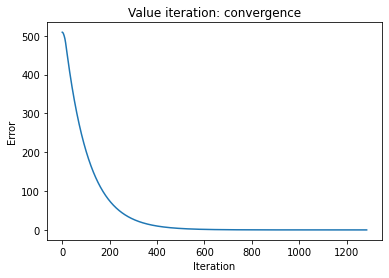

In [69]:
# Parameters
tol = 1e-5
gamma = 0.99

# Environment
env = get_env()

# run value iteration to obtain Q-values
VI_Q, VI_greedypol, all_qfunctions = value_iteration(env.P, env.R, gamma=gamma, tol=tol)

# render the policy
print("[VI]Greedy policy: ")
render_policy(env, VI_greedypol)

# compute the value function of the greedy policy using matrix inversion
# ====================================================
# YOUR IMPLEMENTATION HERE 
# compute value function of the greedy policy
greedy_V = policy_evaluation(env.P, env.R, VI_greedypol, gamma, tol)

# ====================================================

# show the error between the computed V-functions and the final V-function
# (that should be the optimal one, if correctly implemented)
# as a function of time
final_V = all_qfunctions[-1].max(axis=1)
norms = [ np.linalg.norm(q.max(axis=1) - final_V) for q in all_qfunctions]
plt.plot(norms)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title("Value iteration: convergence")

#### POLICY ITERATION ####
PI_policy, PI_V = policy_iteration(env.P, env.R, gamma=gamma, tol=tol)
print("\n[PI]final policy: ")
render_policy(env, PI_policy)

## Uncomment below to check that everything is correct
assert np.allclose(PI_policy, VI_greedypol),\
    "You should check the code, the greedy policy computed by VI is not equal to the solution of PI"
assert np.allclose(PI_V, greedy_V),\
    "Since the policies are equal, even the value function should be"

plt.show()

# Part 2 - Tabular RL

## Question 2.1

The code below collects two datasets of transitions (containing states, actions, rewards and next states) for a discrete MDP.

For each of the datasets:

1. Estimate the transitions and rewards, $\hat{P}$ and $\hat{R}$.
2. Compute the optimal value function and the optimal policy with respect to the estimated MDP (defined by $\hat{P}$ and $\hat{R}$), which we denote by $\hat{\pi}$ and $\hat{V}$.
3. Numerically compare the performance of $\hat{\pi}$ and $\pi^\star$ (the true optimal policy), and the error between $\hat{V}$ and $V^*$ (the true optimal value function).

Which of the two data collection methods do you think is better? Why?

### **Answer**

Based on experimentation it seems that the optimal policy obtained by sampling the MDP using uniform sampling is closer to the real optimal policy. 

This matches the intuition that unfiromly sampling states and actions can be better than sampling states by running a random policy. In order to get a good approximation of the optimal policy, we need good estimates mostly of the states with higher rewards, because they'll end up being selected by that optimal policy. I.e for states with value 0, we don't really need to get better approximations, because their value will still be 0. 

In this case where most of the states have 0 value, is more likely to select the ones different than 0, by just taking samples uniformly rather than following a random policy. I.e it's more probable to just sample one state than to actually sampling a set of N actions that end up in that state.

In [70]:
def get_random_policy_dataset(env, n_samples):
  """Get a dataset following a random policy to collect data."""
  states = []
  actions = []
  rewards = []
  next_states = []
  
  state = env.reset()
  for _ in range(n_samples):
    action = env.action_space.sample()
    next_state, reward, is_terminal, info = env.step(action)
    states.append(state)
    actions.append(action)
    rewards.append(reward)
    next_states.append(next_state)
    # update state
    state = next_state
    if is_terminal:
      state = env.reset()

  dataset = (states, actions, rewards, next_states)
  return dataset

def get_uniform_dataset(env, n_samples):
  """Get a dataset by uniformly sampling states and actions."""
  states = []
  actions = []
  rewards = []
  next_states = []
  for _ in range(n_samples):
    state = env.observation_space.sample()
    action = env.action_space.sample()
    next_state, reward, is_terminal, info = env.sample(state, action)
    states.append(state)
    actions.append(action)
    rewards.append(reward)
    next_states.append(next_state)

  dataset = (states, actions, rewards, next_states)
  return dataset


# Collect two different datasets
num_samples = 500
env = get_env()
dataset_1 = get_random_policy_dataset(env, num_samples)
dataset_2 = get_uniform_dataset(env, num_samples)


# Item 3: Estimate the MDP with the two datasets; compare the optimal value
# functions in the true and in the estimated MDPs
def estimate_mdp(dataset):
  # Assuming that we sample all states and actions of the MDP
  number_of_states = np.max(dataset[0]+dataset[3]) + 1
  number_of_actions = np.max(dataset[1]) + 1
  # Estimated rewards
  R = np.zeros([number_of_states, number_of_actions])
  # Count of (s,a,s') transitions
  N = np.zeros([number_of_states, number_of_actions, number_of_states], dtype=np.int64)
  for transition in zip(*dataset):
    state = transition[0]
    action = transition[1]
    reward = transition[2]
    next_state = transition[3]
    N[state, action, next_state] = 1
    R[state, action] += (1/N[state, action].sum()) * (reward - R[state, action])
  # Estimated transitions
  P = np.nan_to_num((N / N.sum(axis=2)[:, :, np.newaxis]))
  return P, R

# Estimated MDPs
P1, R1 = estimate_mdp(dataset_1)
P2, R2 = estimate_mdp(dataset_2)

# Evaluation
# Optimal policy is obtained by Policy Iteration
optimal_policy, optimal_v = policy_iteration(env.P, env.R)
policy_1, v_1 = policy_iteration(P1, R1)
policy_2, v_2 = policy_iteration(P2, R2)

print("||V1* - V*|| =", np.linalg.norm(optimal_v - v_1, ord=np.inf))
print("||V2* - V*|| =", np.linalg.norm(optimal_v - v_2, ord=np.inf))

print("Number of states in which P1* and P* differ: ", np.sum((optimal_policy - policy_1) != 0))
print("Number of states in which P2* and P* differ: ", np.sum((optimal_policy - policy_2) != 0))

print("P*")
render_policy(env, optimal_policy)

print("P1*")
render_policy(env, policy_1)

print("P2*")
render_policy(env, policy_2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in true_divide


||V1* - V*|| = 8.801722037149576
||V2* - V*|| = 0.660868081057
Number of states in which P1* and P* differ:  13
Number of states in which P2* and P* differ:  9
P*


P1*


P2*


## Question 2.2

Suppose that $\hat{P}$ and $\hat{R}$ are estimated from a dataset of exactly $N$ i.i.d. samples from **each** state-action pair. This means that, for each $(s,a)$, we have $N$ samples $\{(s_1',r_1, \dots, s_N', r_N\}$, where $s_i' \sim P(\cdot | s,a)$ and $r_i \sim R(s,a)$ for $i=1,\dots,N$, and
$$ \hat{P}(s'|s,a) = \frac{1}{N}\sum_{i=1}^N \mathbb{1}(s_i' = s'), $$
$$ \hat{R}(s,a) = \frac{1}{N}\sum_{i=1}^N r_i.$$
Suppose that $R$ is a distribution with support in $[0,1]$. Let $\hat{V}$ be the optimal value function computed in the empirical MDP (i.e., the one with transitions $\hat{P}$ and rewards $\hat{R}$). For any $\delta\in(0,1)$, derive an upper bound to the error

$$ \| \hat{V} - V^* \|_\infty $$

which holds with probability at least $1-\delta$.

**Note** Your bound should only depend on deterministic quantities like $N$, $\gamma$, $\delta$, $S$, $A$. It should *not* dependent on the actual random samples.

**Hint** The following two inequalities may be helpful.

1. **A (simplified) simulation lemma**. For any state $\bar{s}$,

$$ |\hat{V}(\bar{s}) - V^*(\bar{s})| \leq \frac{1}{1-\gamma}\max_{s,a} \left| R(s,a) - \hat{R}(s,a) + \gamma \sum_{s'}(P(s'|s,a) - \hat{P}(s'|s,a)) V^*(s') \right|$$

2. **Hoeffding's inequality**. Let $X_1, \dots X_N$ be $N$ i.i.d. random variables bounded in the interval $[0,b]$ for some $b>0$. Let $\bar{X} = \frac{1}{N}\sum_{i=1}^N X_i$ be the empirical mean. Then, for any $\epsilon > 0$,

$$ \mathbb{P}(|\bar{X} - \mathbb{E}[\bar{X}]| > \epsilon) \leq 2e^{-\frac{2N\epsilon^2}{b^2}}.$$

### **Answer**

From the simulation lemma, if that holds for any state, then it will also hold for the state in which the difference $\hat{V}(s) - V^*(s)$ is maximum, so

$||\hat{V}-V^*||_{\infty} \leq \frac{1}{1-\gamma} \max_{s,a}\bigg|R(s,a) - \hat{R}(s,a) + \gamma \sum_{s'} (P(s'|s,a) - \hat{P}(s'|s,a))V^*(s')\bigg|$

For each state-action pair we have N iid samples $\{r_i\}$ samples which are bounded in $[0,1]$. Let $\hat{R}(s,a) = \frac{1}{N}\sum_i r_i$. Then by Hoeffding's inequality, we have that, for all state-action pairs, for any $ϵ>0$

$\mathbb{P}(|\hat{R}(s,a) - \mathbb{E}(\hat{R}(s,a)| > \epsilon) \leq 2e^{-2N\epsilon^2}$

$\mathbb{P}(|\hat{R}(s,a) - R(s,a)| < \epsilon) \geq 1 - 2e^{-2N\epsilon^2}$

The probabilitiy of the maximum being smaller than some $\epsilon$, is the probability of the rewards in all state-action pairs being smaller than that $\epsilon$. Since the reward in each state-action, only depends on that state-action because of the Markov property of MDPs, all the rewards are independent and we can take the product of their probabilities.

$\mathbb{P}(\max|\hat{R}(s,a) - R(s,a)| < \epsilon) \geq (1 - 2e^{-2N\epsilon^2})^{SA}$

The same reasoning can be done for the state transitions. For each state $s_n$ we can define the random variable $\mathbb{1}(s'=s_n | s,a)$, note that for each of those we have N iid random samples. All of these variables are trivially bounded in $[0,1]$. Then, we can apply again Hoeffding's inequality. For each state-action pair and for any $ϵ>0$

$\mathbb{P}(|\hat{P}(s'|s,a) - P(s'|s,a)| \leq \epsilon) \geq 1-2e^{-2Nϵ^2}$

Then because of Markov property, the same independendency hypothesis holds for the state transitions

$\mathbb{P}(\max|\hat{P}(s'|s,a) - P(s'|s,a)| \leq \epsilon) \geq (1-2e^{-2Nϵ^2})^{SA}$

Note now that since $R(s,a)$ is bounded by 1

$V^*(s) = \mathbb{E}[\sum_t\gamma^tr(s_t,a_t|s_{t-1}=s_i, \pi^*)] \leq \mathbb{E}[\sum_t \gamma^t] = \frac{1}{1-\gamma}$

Then

$||\hat{V}-V^*||_{\infty} \leq \frac{1}{1-\gamma} \bigg[\max_{s,a} |R(s,a) - \hat{R}(s,a)| + \frac{1}{1-\gamma}\max_{s,a}|\sum_{s'}P(s'|s,a) - \hat{P}(s'|s,a)|\bigg]$

$... \leq \frac{1}{1-\gamma} \bigg[\max_{s,a}|R(s,a) - \hat{R}(s,a)| + \frac{1}{1-\gamma}\sum_{s'} \max_{s,a}|P(s'|s,a) - \hat{P}(s'|s,a)| \bigg]$

Assuming that next states and rewards are independent, we can apply the bounds obtained by Hoeffding's inequality. The intersection of both maximums being bounded by $\epsilon$ is the product of both probabilities

$\mathbb{P}(||\hat{V}-V^*||_\infty \leq \frac{1}{1-\gamma}[\epsilon + \frac{\gamma}{1-\gamma}\sum_s'\epsilon]) \geq (1-2e^{-2N\epsilon^2})^{2SA}$

Then with probability at least $(1-2e^{-2N\epsilon^2})^{2SA}$

$||\hat{V}-V^*||_\infty \leq \frac{\epsilon(1+\gamma(s-1))}{(1-\gamma)^2}$

Taking the following identity, we can express this in a more compact form

$1-\delta = (1-2e^{-2N\epsilon^2})^{2SA}$

$(1-\delta) ^{\frac{1}{2SA}} = 1-2e^{-2N\epsilon^2}$

$\epsilon = \sqrt{\frac{\log(2) - \log(1-(1-\delta) ^{\frac{1}{2SA}})}{2N}}$

Then

$||\hat{V}-V^*||_\infty \leq \frac{1+\gamma(s-1)}{(1-\gamma)^2} \epsilon(S,A,N,\delta)$ with probability at least $1-\delta$

## Question 2.3

Suppose once again that we are given a dataset of $N$ samples in the form of tuples $(s_i,a_i,s_i',r_i)$. We know that each tuple contains a valid transition from the true MDP, i.e., $s_i' \sim P(\cdot | s_i, a_i)$ and $r_i \sim R(s_i,a_i)$, while the state-action pairs $(s_i,a_i)$ from which the transition started can be arbitrary.

Suppose we want to apply Q-learning to this MDP. Can you think of a way to leverage this offline data to improve the sample-efficiency of the algorithm? What if we were using SARSA instead?

### **Answer**

Yes, the setting described is exactly what Dyna-Q does. I'd alternate between learning and planning steps. The learning steps are regular Q-learning updates. Between those steps, one can sample states and actions from the dataset and use the estimates $\hat{P}(s'|s,a)$ and $\hat{R}(s,a)$ for making updates of the Q function, with the same idea as Q-learning (the only difference is that the reward and transition is simulated and not returned by the "real" environment). This is possible for Q-learning because it's an off-policy algorithm.

On the other hand, if we were using SARSA we cannot do the same, since SARSA updates rely on having a target policy close to the behavioral policy, which is known as on-policy control. For SARSA to be able to include planning steps, we need that the state-action pairs from the dataset, to follow a policy "close" to the behavioral policy.

# Part 3 - RL with Function Approximation

## Question 3.1

Given a datset $(s_i, a_i, r_i, s_i')$ of (states, actions, rewards, next states), the Fitted Q-Iteration (FQI) algorithm proceeds as follows:


* We start from a $Q$ function $Q_0 \in \mathcal{F}$, where $\mathcal{F}$ is a function space;
* At every iteration $k$, we compute $Q_{k+1}$ as:

$$
Q_{k+1}\in\arg\min_{f\in\mathcal{F}} \frac{1}{2}\sum_{i=1}^N
\left(
  f(s_i, a_i) - y_i^k
\right)^2 + \lambda \Omega(f)
$$
where $y_i^k = r_i + \gamma \max_{a'}Q_k(s_i', a')$, $\Omega(f)$ is a regularization term and $\lambda > 0$ is the regularization coefficient.


Consider FQI with *linear* function approximation. That is, for a given feature map $\phi : S \rightarrow \mathbb{R}^d$, we consider a parametric family of $Q$ functions $Q_\theta(s,a) = \phi(s)^T\theta_a$ for $\theta_a\in\mathbb{R}^d$. Suppose we are applying FQI on a given dataset of $N$ tuples of the form $(s_i, a_i, r_i, s_i')$ and we are at the $k$-th iteration. Let $\theta_k \in\mathbb{R}^{d \times A}$ be our current parameter. Derive the *closed-form* update to find $\theta_{k+1}$, using $\frac{1}{2}\sum_a ||\theta_a||_2^2$ as regularization.

### **Answer**

The quantity to minimize is the following, with $\Theta=\{\theta_i\}_{i=1, ..., \#A}$:

$l^{k+1}(\Theta) = \frac{1}{2}\sum_i^N\big(\phi(s_i)^T \theta_{a_i} - y_i^k\big)^2 + \frac{\lambda}{2}\sum_a||\theta_a||^2_2$

With linear function approximation, the minimum has a closed form that can be obtained by taking the gradients respect to $\theta_a$ and setting them to 0. For each $a_i$:

$\nabla l(\Theta)^{k+1}_{\theta_{a_i}} = \sum_{j/a_j=a_i}\big(\phi(s_j)^T \theta_{a_i} - y_j^k\big)\phi(s_j) + \lambda \theta_{a_i}$

$[\sum_{j/a_j=a_i}\big(\phi(s_j)\phi(s_j)^T\big)  + \lambda I_{dxd}]\theta_{a_i} - \sum_{j/a_j=a_i} y^k_j\phi(s_j) = 0$

$\theta_{a_i}^{k+1} = [\sum_{j/a_j=a_i}\big(\phi(s_j)\phi(s_j)^T\big)  + \lambda I_{dxd}]^{-1} \sum_{j/a_j=a_i} y^k_j\phi(s_j)$

## Question 3.2

The code below creates a larger gridworld (with more states than the one used in the previous questions), and defines a feature map. Implement linear FQI to this environment (in the function `linear_fqi()` below), and compare the approximated $Q$ function to the optimal $Q$ function computed with value iteration.

Can you improve the feature map in order to reduce the approximation error?

### **Answer**

One of the strategies I tried for reducing the approximation error was increasing the dimension of the feature map. Since the capacity of a linear model is essentially given by the dimension of the feature map, it makes sense that if we have a richer representation of the states then our approximation of the optimal policy will be better. We can also increase the number of samples for the dataset and the number of iterations during training.

In [71]:
def get_large_gridworld():
  """Creates an instance of a grid-world MDP with more states."""
  walls = [(ii, 10) for ii in range(15) if (ii != 7 and ii != 8)]
  env = GridWorld(
      nrows=15,
      ncols=15,
      reward_at = {(14, 14):1.0},
      walls=tuple(walls),
      success_probability=0.9,
      terminal_states=((14, 14),)
  )
  return env


class GridWorldFeatureMap:
  """Create features for state-action pairs
  
  Args:
    dim: int
      Feature dimension
    sigma: float
      RBF kernel bandwidth
  """
  def __init__(self, env, dim=15, sigma=0.25):
    self.index2coord = env.index2coord
    self.n_states = env.Ns
    self.n_actions = env.Na
    self.dim = dim
    self.sigma = sigma

    n_rows = env.nrows
    n_cols = env.ncols

    # build similarity matrix
    sim_matrix = np.zeros((self.n_states, self.n_states))
    for ii in range(self.n_states):
        row_ii, col_ii = self.index2coord[ii]
        x_ii = row_ii / n_rows
        y_ii = col_ii / n_cols
        for jj in range(self.n_states):
            row_jj, col_jj = self.index2coord[jj]
            x_jj = row_jj / n_rows
            y_jj = col_jj / n_cols
            dist = np.sqrt((x_jj - x_ii) ** 2.0 + (y_jj - y_ii) ** 2.0)
            sim_matrix[ii, jj] = np.exp(-(dist / sigma) ** 2.0)

    # factorize similarity matrix to obtain features
    uu, ss, vh = np.linalg.svd(sim_matrix, hermitian=True)
    self.feats = vh[:dim, :]

  def map(self, observation):
    feat = self.feats[:, observation].copy()
    return feat

In [72]:
env = get_large_gridworld()
feat_map = GridWorldFeatureMap(env)

# Visualize large gridworld
render_policy(env)

# The features have dimension (feature_dim).
feature_example = feat_map.map(1) # feature representation of s=1
print(feature_example)

# Initial vector theta representing the Q function
theta = np.zeros((feat_map.dim, env.action_space.n))
print(theta.shape)
print(feature_example @ theta) # approximation of Q(s=1, a)

[-0.02850699  0.063555   -0.02169407 -0.06441918  0.04505794 -0.07537777
  0.08506473 -0.09325287  0.09644275 -0.00535101  0.11632395 -0.13074085
  0.00921342 -0.13853662  0.07118419]
(15, 4)
[0. 0. 0. 0.]


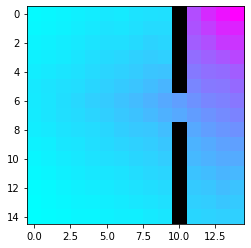

In [73]:
def linear_fqi(env, feat_map, num_iterations, lambd=0.1, gamma=0.95):
  """
  # Linear FQI implementation
  # TO BE COMPLETED
  """

  # get a dataset
  dataset = get_uniform_dataset(env, n_samples=5000)
  # OR dataset = get_random_policy_dataset(env, n_samples=...)


  theta = np.zeros((feat_map.dim, env.Na))

  next_states = np.array(dataset[3])
  rewards = np.array(dataset[2])
  actions = np.array(dataset[1])
  states = np.array(dataset[0])
  
  states_map = feat_map.map(states)
  next_states_map = feat_map.map(next_states)
  for it in range(num_iterations):    
    # Compute target
    targets = rewards + gamma * np.max(next_states_map.T @ theta, axis=1)
    # Solve the linear regression for each action
    for action in range(env.Na):
      trajectories = [i[0] for i in np.argwhere(actions == action)]
      target = targets[trajectories]
      state = states_map[:, trajectories]
      theta[:, action] = np.linalg.solve( lambd * np.eye(theta.shape[0]) + state@state.T, state@target)
  
  return theta

# ----------------------------
# Environment and feature map
# ----------------------------
env = get_large_gridworld()
# you can change the parameters of the feature map, and even try other maps!
feat_map = GridWorldFeatureMap(env, dim=150, sigma=0.25)

# -------
# Run FQI
# -------
theta = linear_fqi(env, feat_map, num_iterations=100, lambd=0.1)

# Compute and run greedy policy
Q_fqi = np.zeros((env.Ns, env.Na))
for ss in range(env.Ns):
  state_feat = feat_map.map(ss)
  Q_fqi[ss, :] = state_feat @ theta

V_fqi = Q_fqi.max(axis=1)
policy_fqi = Q_fqi.argmax(axis=1)
render_policy(env, policy_fqi, horizon=100)

# Visualize the approximate value function in the gridworld.
img = env.get_layout_img(V_fqi)    
plt.imshow(img)
plt.show()

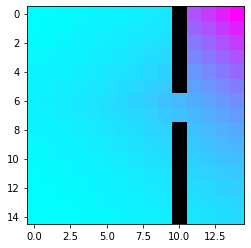

In [74]:
# Value iteration
VI_Q, VI_greedypol, all_qfunctions = value_iteration(env.P, env.R, tol=1e-16)
render_policy(env, VI_greedypol, horizon=100)

# Visualize the optimal value function obtained by value iteration in the gridworld.
VI_V = VI_Q.max(axis=1)
img = env.get_layout_img(VI_V)
plt.imshow(img)
plt.show()

In [75]:
# Q functions comparison
print("||Q* - Qfqi|| =", np.linalg.norm(VI_Q - Q_fqi, ord=np.inf))

||Q* - Qfqi|| = 28.866078865440628
